In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 1000)
import datetime
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import time
import os
import copy

In [ ]:
tmp = pd.read_csv('白银88.csv', encoding="gbk", engine='python')
tmp.rename(columns={'Unnamed: 0':'trading_time'}, inplace=True)
tmp['trading_point'] = pd.to_datetime(tmp.trading_time)
del tmp['trading_time']
tmp.set_index(tmp.trading_point, inplace=True)

In [2]:
def fix_data(path):
    tmp = pd.read_csv(path, encoding="gbk", engine='python')
    tmp.rename(columns={'Unnamed: 0':'trading_time'}, inplace=True)
    tmp['trading_point'] = pd.to_datetime(tmp.trading_time)
    del tmp['trading_time']
    tmp.set_index(tmp.trading_point, inplace=True)
    return tmp

def High_2_Low(tmp, freq):
    """处理从RiceQuant下载的分钟线数据，
    从分钟线数据合成低频数据
    2017-08-11    
    """
    # 分别处理bar数据
    tmp_open = tmp['open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['high'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)
    
    # 处理成交量
    tmp_volume = tmp['volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)
    
    return pd.concat([tmp_price, tmp_volume], axis=1)

In [3]:
import talib 

def get_factors(index, 
                Open, 
                Close, 
                High, 
                Low, 
                Volume,
                rolling = 26,
                drop=False, 
                normalization=True):
    
    tmp = pd.DataFrame()
    tmp['tradeTime'] = index
    
    #累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    #用以计算成交量的动量。属于趋势型因子
    tmp['AD'] = talib.AD(High, Low, Close, Volume)

    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    tmp['ADOSC'] = talib.ADOSC(High, Low, Close, Volume, fastperiod=3, slowperiod=10)

    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADX'] = talib.ADX(High, Low, Close,timeperiod=14)

    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADXR'] = talib.ADXR(High, Low, Close,timeperiod=14)

    # 绝对价格振荡指数
    tmp['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26)

    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    #Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    tmp['AROONDown'], tmp['AROONUp'] = talib.AROON(High, Low,timeperiod=14)
    tmp['AROONOSC'] = talib.AROONOSC(High, Low,timeperiod=14)

    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    #是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    tmp['ATR14']= talib.ATR(High, Low, Close, timeperiod=14)
    tmp['ATR6']= talib.ATR(High, Low, Close, timeperiod=6)

    # 布林带
    tmp['Boll_Up'],tmp['Boll_Mid'],tmp['Boll_Down']= talib.BBANDS(Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # 均势指标
    tmp['BOP'] = talib.BOP(Open, High, Low, Close)

    #5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    tmp['CCI5'] = talib.CCI(High, Low, Close, timeperiod=5)
    tmp['CCI10'] = talib.CCI(High, Low, Close, timeperiod=10)
    tmp['CCI20'] = talib.CCI(High, Low, Close, timeperiod=20)
    tmp['CCI88'] = talib.CCI(High, Low, Close, timeperiod=88)

    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    tmp['CMO_Close'] = talib.CMO(Close,timeperiod=14)
    tmp['CMO_Open'] = talib.CMO(Close,timeperiod=14)

    # DEMA双指数移动平均线
    tmp['DEMA6'] = talib.DEMA(Close, timeperiod=6)
    tmp['DEMA12'] = talib.DEMA(Close, timeperiod=12)
    tmp['DEMA26'] = talib.DEMA(Close, timeperiod=26)

    # DX 动向指数
    tmp['DX'] = talib.DX(High, Low, Close,timeperiod=14)

    # EMA 指数移动平均线
    tmp['EMA6'] = talib.EMA(Close, timeperiod=6)
    tmp['EMA12'] = talib.EMA(Close, timeperiod=12)
    tmp['EMA26'] = talib.EMA(Close, timeperiod=26)

    # KAMA 适应性移动平均线
    tmp['KAMA'] = talib.KAMA(Close, timeperiod=30)

    # MACD
    tmp['MACD_DIF'],tmp['MACD_DEA'],tmp['MACD_bar'] = talib.MACD(Close, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    tmp['MEDPRICE'] = talib.MEDPRICE(High, Low)

    # 负向指标 负向运动
    tmp['MiNUS_DI'] = talib.MINUS_DI(High, Low, Close,timeperiod=14)
    tmp['MiNUS_DM'] = talib.MINUS_DM(High, Low,timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    #减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    tmp['MOM'] = talib.MOM(Close, timeperiod=10)

    # 归一化平均值范围
    tmp['NATR'] = talib.NATR(High, Low, Close,timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    #从而研判股价的走势。属于成交量型因子
    tmp['OBV'] = talib.OBV(Close, Volume)

    # PLUS_DI 更向指示器
    tmp['PLUS_DI'] = talib.PLUS_DI(High, Low, Close,timeperiod=14)
    tmp['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)

    # PPO 价格振荡百分比
    tmp['PPO'] = talib.PPO(Close, fastperiod=6, slowperiod= 26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    #通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROC6'] = talib.ROC(Close, timeperiod=6)
    tmp['ROC20'] = talib.ROC(Close, timeperiod=20)
    #12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    #通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    #达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    #属于成交量的反趋向指标。属于成交量型因子
    tmp['VROC6'] = talib.ROC(Volume, timeperiod=6)
    tmp['VROC20'] = talib.ROC(Volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    #通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROCP6'] = talib.ROCP(Close, timeperiod=6)
    tmp['ROCP20'] = talib.ROCP(Close, timeperiod=20)
    #12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    #通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    #达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    #属于成交量的反趋向指标。属于成交量型因子
    tmp['VROCP6'] = talib.ROCP(Volume, timeperiod=6)
    tmp['VROCP20'] = talib.ROCP(Volume, timeperiod=20)

    # RSI
    tmp['RSI'] = talib.RSI(Close, timeperiod=14)

    # SAR 抛物线转向
    tmp['SAR'] = talib.SAR(High, Low, acceleration=0.02, maximum=0.2)

    # TEMA
    tmp['TEMA6'] = talib.TEMA(Close, timeperiod=6)
    tmp['TEMA12'] = talib.TEMA(Close, timeperiod=12)
    tmp['TEMA26'] = talib.TEMA(Close, timeperiod=26)

    # TRANGE 真实范围
    tmp['TRANGE'] = talib.TRANGE(High, Low, Close)

    # TYPPRICE 典型价格
    tmp['TYPPRICE'] = talib.TYPPRICE(High, Low, Close)

    # TSF 时间序列预测
    tmp['TSF'] = talib.TSF(Close, timeperiod=14)

    # ULTOSC 极限振子
    tmp['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

    # 威廉指标
    tmp['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)
    
    # 标准化
    if normalization:
        factors_list = tmp.columns.tolist()[1:]

        if rolling >= 26:
            for i in factors_list:
                tmp[i] = (tmp[i] - tmp[i].rolling(window=rolling, center=False).mean())\
                /tmp[i].rolling(window=rolling, center=False).std()
        elif rolling < 26 & rolling > 0:
            print ('Recommended rolling range greater than 26')
        elif rolling <=0:
            for i in factors_list:
                tmp[i] = (tmp[i] - tmp[i].mean())/tmp[i].std()
            
    if drop:
        tmp.dropna(inplace=True)
        
    tmp.set_index('tradeTime', inplace=True)
    
    return tmp

In [4]:
tmp = fix_data('白银88.csv')

# targets 1d 数据合成
tmp_1d = High_2_Low(tmp, '1d')
rolling = 88
targets = tmp_1d
targets['returns'] =  targets['close'].shift(-2) / targets['close'] - 1.0
targets['upper_boundary']= targets.returns.rolling(rolling).mean() + 0.5 * targets.returns.rolling(rolling).std()
targets['lower_boundary']= targets.returns.rolling(rolling).mean() - 0.5 * targets.returns.rolling(rolling).std()
targets.dropna(inplace=True)
targets['labels'] = 1
targets.loc[targets['returns']>=targets['upper_boundary'], 'labels'] = 2
targets.loc[targets['returns']<=targets['lower_boundary'], 'labels'] = 0

# factors 1d 数据合成
tmp_1d = High_2_Low(tmp, '1d')
Index = tmp_1d.index
High = tmp_1d.high.values
Low = tmp_1d.low.values
Close = tmp_1d.close.values
Open = tmp_1d.open.values
Volume = tmp_1d.volume.values
factors = get_factors(Index, Open, Close, High, Low, Volume, rolling = 26, drop=True)

factors = factors.loc[:targets.index[-1]]

tmp_factors_1 = factors.iloc[:12]
targets = targets.loc[tmp_factors_1.index[-1]:]

gather_list = np.arange(factors.shape[0])[11:]

In [5]:
inputs = np.array(factors).reshape(-1, 1, factors.shape[1])

def dense_to_one_hot(labels_dense):
    """标签 转换one hot 编码
    输入labels_dense 必须为非负数
    2016-11-21
    """
    num_classes = len(np.unique(labels_dense)) # np.unique 去掉重复函数
    raws_labels = labels_dense.shape[0]
    index_offset = np.arange(raws_labels) * num_classes
    labels_one_hot = np.zeros((raws_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot  

targets = dense_to_one_hot(targets['labels'])
targets = np.expand_dims(targets, axis=1)

In [6]:


import tensorflow as tf
from DNCore import DNCoreDeepLSTM



In [7]:
class Classifier_DNCoreDeepLSTM(object):
    
    def __init__(self, 
                 inputs, 
                 targets,
                 gather_list=None,
                 batch_size=1, 
                 hidden_size=20, 
                 memory_size=20, 
                 num_reads=3,
                 num_writes=1,  
                 learning_rate = 1e-3,
                 optimizer_epsilon = 1e-8,
                 l2_coefficient = 1e-3,
                 max_gard_norm = 50,
                 reset_graph = True):
        
        if reset_graph:
            tf.reset_default_graph()
        # 控制参数
        self._tmp_inputs = inputs
        self._tmp_targets = targets
        self._in_length = None
        self._in_width = inputs.shape[2]
        self._out_length = None
        self._out_width = targets.shape[2]
        self._batch_size = batch_size

        # 声明会话
        self._sess = tf.InteractiveSession()
        
        self._inputs = tf.placeholder(
            dtype=tf.float32,
            shape=[self._in_length, self._batch_size, self._in_width],
            name='inputs')
        self._targets = tf.placeholder(
            dtype=tf.float32,
            shape=[self._out_length, self._batch_size, self._out_width],
            name='targets')
        
        self._RNNCoreCell = DNCoreDeepLSTM(
            dnc_output_size=self._out_width, 
            hidden_size=hidden_size, 
            memory_size=memory_size, 
            word_size=self._in_width, 
            num_read_heads=num_reads,
            num_write_heads=num_writes)
        
        self._initial_state = \
        self._RNNCoreCell.initial_state(batch_size)
        
        output_sequences, _ = \
        tf.nn.dynamic_rnn(cell= self._RNNCoreCell, 
                          inputs=self._inputs, 
                          initial_state=self._initial_state, 
                          time_major=True)
        
        self._original_output_sequences = output_sequences
        if gather_list is not None:
            output_sequences = tf.gather(output_sequences, gather_list)
        
        # L2 正则化测试 2017-09-03 
        self._trainable_variables = tf.trainable_variables()
        _l2_regularizer = tf.add_n([tf.nn.l2_loss(v) for v in self._trainable_variables])        
        self._l2_regularizer = _l2_regularizer * l2_coefficient / len(self._trainable_variables)
        
        rnn_cost = tf.nn.softmax_cross_entropy_with_logits(
            labels=self._targets, logits=output_sequences)
        self._rnn_cost = tf.reduce_mean(rnn_cost)
        self._cost = self._rnn_cost + self._l2_regularizer
        
        
        train_pred = tf.nn.softmax(output_sequences, dim=2)
        correct_pred = tf.equal(tf.argmax(train_pred,2), tf.argmax(self._targets,2))
        self._accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        # Set up optimizer with global norm clipping.
        trainable_variables = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self._cost, trainable_variables), max_gard_norm)
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])
        
        optimizer = tf.contrib.opt.NadamOptimizer(
            learning_rate=learning_rate, epsilon=optimizer_epsilon)
        self._train_step = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)  
        
        self._sess.run(tf.global_variables_initializer())
        self._variables_saver = tf.train.Saver()
        
        
    def fit(self, 
            training_iters =1e2,             
            display_step = 5, 
            save_path = None,
            restore_path = None):
        
        if restore_path is not None:
            self._variables_saver.restore(self._sess, restore_path)
              
        for scope in range(np.int(training_iters)):
            self._sess.run([self._train_step],
                           feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets})
            
            if scope % display_step == 0:
                loss, acc, l2_loss, rnn_loss = self._sess.run(
                    [self._cost, self._accuracy, self._l2_regularizer, self._rnn_cost], 
                    feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets}) 
                print (scope, '  loss--', loss, '  acc--', acc, '  l2_loss', l2_loss, '  rnn_cost', rnn_loss)                       
                    
        print ("Optimization Finished!")         
        loss, acc, l2_loss, rnn_loss = self._sess.run(
            [self._cost, self._accuracy, self._l2_regularizer, self._rnn_cost], 
            feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets}) 
        print ('Model assessment  loss--', loss, '  acc--', acc, '  l2_loss', l2_loss, '  rnn_cost', rnn_loss)      
        # 保存模型可训练变量
        if save_path is not None:
            self._variables_saver.save(self._sess, save_path) 
            
    def close(self):
        self._sess.close()
        print ('结束进程，清理tensorflow内存/显存占用')
        
    def pred(self, inputs, gather_list=None, restore_path=None):
        output_sequences = self._original_output_sequences
        if gather_list is not None:
            output_sequences = tf.gather(output_sequences, gather_list)
        probability = tf.nn.softmax(output_sequences)
        classification = tf.argmax(probability, axis=-1)
        return self._sess.run([probability, classification],feed_dict = {self._inputs:inputs})
    
    def restore_trainable_variables(self, restore_path):
        self._variables_saver.restore(self._sess, restore_path)
    
    def score(self, inputs, targets, gather_list=None):
        acc = self._sess.run(
            self._accuracy,
            feed_dict = {self._inputs:self._tmp_inputs, 
                         self._targets:self._tmp_targets})
        return acc

In [8]:
a = Classifier_DNCoreDeepLSTM(
    inputs, 
    targets, 
    gather_list,
    hidden_size=50, 
    memory_size=50, 
    learning_rate = 1e-3, 
    l2_coefficient=5e-3)

a.fit(training_iters = 200,
      display_step=5, 
      save_path='models/DNCoreDeepLSTM_NADM_saver_1.ckpt')

print (a.score(inputs, targets, gather_list))
a.close()

C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0   loss-- 1.09281   acc-- 0.526316   l2_loss 0.0659313   rnn_cost 1.02688
5   loss-- 1.02713   acc-- 0.527665   l2_loss 0.0614453   rnn_cost 0.965682
10   loss-- 0.98058   acc-- 0.562753   l2_loss 0.0579541   rnn_cost 0.922626
15   loss-- 0.922155   acc-- 0.60054   l2_loss 0.0553224   rnn_cost 0.866832
20   loss-- 0.893449   acc-- 0.624831   l2_loss 0.0535735   rnn_cost 0.839875
25   loss-- 0.848152   acc-- 0.645074   l2_loss 0.052348   rnn_cost 0.795804
30   loss-- 0.796935   acc-- 0.673414   l2_loss 0.0514242   rnn_cost 0.745511
35   loss-- 0.762292   acc-- 0.699055   l2_loss 0.0506903   rnn_cost 0.711601
40   loss-- 0.720458   acc-- 0.720648   l2_loss 0.0501767   rnn_cost 0.670281
45   loss-- 0.660459   acc-- 0.754386   l2_loss 0.0497921   rnn_cost 0.610667
50   loss-- 0.611539   acc-- 0.792173   l2_loss 0.0495377   rnn_cost 0.562002
55   loss-- 0.574541   acc-- 0.79892   l2_loss 0.0493949   rnn_cost 0.525146
60   loss-- 0.548884   acc-- 0.811066   l2_loss 0.0493153   rnn_cost 0.49

In [9]:
tf.reset_default_graph()
op1 = Classifier_DNCoreDeepLSTM(
    inputs, 
    targets, 
    gather_list,
    hidden_size=50, 
    memory_size=50, 
    learning_rate = 1e-3, 
    l2_coefficient=5e-3)

op1.fit(training_iters = 5,
      display_step=5, 
      save_path='models/DNCoreDeepLSTM_NADM_saver_1.ckpt',
       restore_path='models/DNCoreDeepLSTM_NADM_saver_1.ckpt')

C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from models/DNCoreDeepLSTM_NADM_saver_1.ckpt
0   loss-- 0.285826   acc-- 0.928475   l2_loss 0.051738   rnn_cost 0.234088
Optimization Finished!
Model assessment  loss-- 0.241938   acc-- 0.948718   l2_loss 0.052124   rnn_cost 0.189814


In [10]:
model = op1

In [11]:
import rqalpha.api as rqa
from rqalpha import run_func

def init(context):
    context.contract = 'AG88'
    context.BarSpan = 200
    context.TransactionRate = '1d'
    context.DataFields = ['datetime', 'open', 'close','high', 'low', 'volume']
    context.DefineQuantity = 5 
    context.func_get_factors = get_factors
    context.model_classifier = model

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


In [12]:
def handle_bar(context, bar_dict):
    
    # 合约池代码 
    contract = context.contract
    #rqa.logger.info('------------------------------------')
    #timepoint = rqa.history_bars(contract, 1, '1d', 'datetime')[0]  
    #timepoint = pd.to_datetime(str(timepoint))
    #timepoint = rqa.get_next_trading_date(timepoint)
    #rqa.logger.info (timepoint)    
    
    # 获取合约报价
    Quotes = rqa.history_bars(
        order_book_id= contract, 
        bar_count= context.BarSpan, 
        frequency= context.TransactionRate,
        fields= context.DataFields)
    Quotes = pd.DataFrame(Quotes)

    # 计算技术分析指标
    tmp_factors = context.func_get_factors(
        index= pd.to_datetime(Quotes['datetime']), 
        Open= Quotes['open'].values, 
        Close= Quotes['close'].values, 
        High= Quotes['high'].values, 
        Low= Quotes['low'].values, 
        Volume=Quotes['volume'].values,
        drop=True)   
    inputs = np.expand_dims(np.array(tmp_factors), axis=1)    
    
    # 模型预测
    probability, classification = context.model_classifier.pred(inputs)
    flag = classification[-1][0]
    rqa.logger.info(str(flag))
    #print (flag)
    
    # 绘制估计概率
    rqa.plot("估空概率", probability[-1][0][0])
    rqa.plot("振荡概率", probability[-1][0][1])
    rqa.plot("估多概率", probability[-1][0][2])
    
    
    # 获取仓位
    cur_position = context.portfolio.accounts['FUTURE'].positions
    
    tmp_buy_quantity = 0
    tmp_sell_quantity = 0
    if cur_position:
        tmp_buy_quantity = cur_position[contract].buy_quantity
        tmp_sell_quantity = cur_position[contract].sell_quantity

    # 沽空
    if flag == 0:
        rqa.logger.info ('沽空')
        
        if tmp_buy_quantity > 0:
            rqa.sell_close(contract, tmp_buy_quantity)            
            rqa.sell_open(contract, context.DefineQuantity)
            rqa.logger.info ('平多单  开空单')
            
        elif tmp_sell_quantity >0:
            rqa.logger.info ('持有空头，不调仓')
        else:
            rqa.sell_open(contract, context.DefineQuantity)
            rqa.logger.info ('开空单')

            
    # 沽多
    if flag == 2:
        rqa.logger.info ('沽多')
        if tmp_sell_quantity > 0:
            rqa.buy_close(contract, tmp_sell_quantity)
            rqa.buy_open(contract, context.DefineQuantity)   
            rqa.logger.info ('平空单  开多单')

        elif tmp_buy_quantity > 0:
            rqa.logger.info ('持有多头，不调仓')
            pass
        else:
            rqa.logger.info ('开多单')
            rqa.buy_open(contract, context.DefineQuantity)   
            
    if flag == 1:
        rqa.logger.info ('振荡区间')
        if tmp_sell_quantity > 0:
            rqa.buy_close(contract, tmp_sell_quantity)
            rqa.logger.info ('平空单')
        if tmp_buy_quantity > 0:
            rqa.sell_close(contract, tmp_buy_quantity)
            rqa.logger.info ('平多单')
        else:
            rqa.logger.info ('空仓规避')

2017-01-03 INFO 0
2017-01-03 INFO 沽空
2017-01-03 INFO 开空单
2017-01-04 INFO 0
2017-01-04 INFO 沽空
2017-01-04 INFO 持有空头，不调仓
2017-01-05 INFO 0
2017-01-05 INFO 沽空
2017-01-05 INFO 持有空头，不调仓
2017-01-06 INFO 0
2017-01-06 INFO 沽空
2017-01-06 INFO 持有空头，不调仓
2017-01-09 INFO 0
2017-01-09 INFO 沽空
2017-01-09 INFO 持有空头，不调仓
2017-01-10 INFO 0
2017-01-10 INFO 沽空
2017-01-10 INFO 持有空头，不调仓
2017-01-11 INFO 0
2017-01-11 INFO 沽空
2017-01-11 INFO 持有空头，不调仓
2017-01-12 INFO 0
2017-01-12 INFO 沽空
2017-01-12 INFO 持有空头，不调仓
2017-01-13 INFO 0
2017-01-13 INFO 沽空
2017-01-13 INFO 持有空头，不调仓
2017-01-16 INFO 0
2017-01-16 INFO 沽空
2017-01-16 INFO 持有空头，不调仓
2017-01-17 INFO 0
2017-01-17 INFO 沽空
2017-01-17 INFO 持有空头，不调仓
2017-01-18 INFO 0
2017-01-18 INFO 沽空
2017-01-18 INFO 持有空头，不调仓
2017-01-19 INFO 0
2017-01-19 INFO 沽空
2017-01-19 INFO 持有空头，不调仓
2017-01-20 INFO 0
2017-01-20 INFO 沽空
2017-01-20 INFO 持有空头，不调仓
2017-01-23 INFO 0
2017-01-23 INFO 沽空
2017-01-23 INFO 持有空头，不调仓
2017-01-24 INFO 0
2017-01-24 INFO 沽空
2017-01-24 INFO 持有空头，不调仓
2017-01-25 IN

2017-07-21 INFO 空仓规避
2017-07-24 INFO 1
2017-07-24 INFO 振荡区间
2017-07-24 INFO 空仓规避
2017-07-25 INFO 0
2017-07-25 INFO 沽空
2017-07-25 INFO 开空单
2017-07-26 INFO 1
2017-07-26 INFO 振荡区间
2017-07-26 INFO 平空单
2017-07-26 INFO 空仓规避
2017-07-27 INFO 1
2017-07-27 INFO 振荡区间
2017-07-27 INFO 空仓规避
2017-07-28 INFO 0
2017-07-28 INFO 沽空
2017-07-28 INFO 开空单
2017-07-31 INFO 0
2017-07-31 INFO 沽空
2017-07-31 INFO 持有空头，不调仓
2017-08-01 INFO 0
2017-08-01 INFO 沽空
2017-08-01 INFO 持有空头，不调仓
2017-08-02 INFO 0
2017-08-02 INFO 沽空
2017-08-02 INFO 持有空头，不调仓
2017-08-03 INFO 0
2017-08-03 INFO 沽空
2017-08-03 INFO 持有空头，不调仓
2017-08-04 INFO 0
2017-08-04 INFO 沽空
2017-08-04 INFO 持有空头，不调仓
2017-08-07 INFO 1
2017-08-07 INFO 振荡区间
2017-08-07 INFO 平空单
2017-08-07 INFO 空仓规避
2017-08-08 INFO 0
2017-08-08 INFO 沽空
2017-08-08 INFO 开空单
2017-08-09 INFO 0
2017-08-09 INFO 沽空
2017-08-09 INFO 持有空头，不调仓
2017-08-10 INFO 0
2017-08-10 INFO 沽空
2017-08-10 INFO 持有空头，不调仓
2017-08-11 INFO 0
2017-08-11 INFO 沽空
2017-08-11 INFO 持有空头，不调仓
2017-08-14 INFO 0
2017-08-14 INF

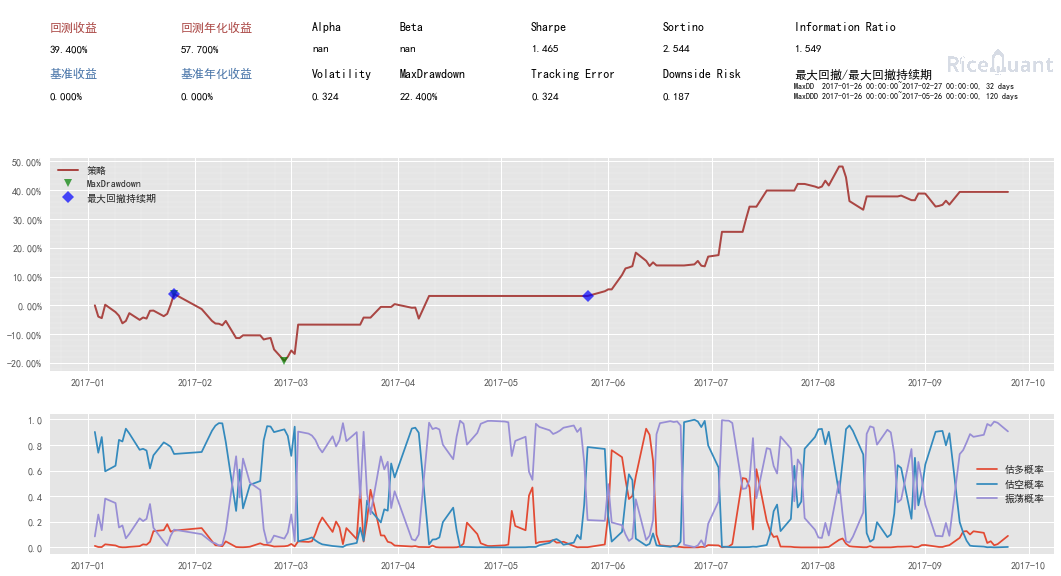

In [13]:
start_date = '2017-01-01'
end_date = '2017-09-25'
accounts = {'future':1e5}

config = {
    'base':{'start_date':start_date, 'end_date':end_date, 'accounts':accounts,' run-type':'p'},
    'extra':{'log_level':'info'},
    'mod':{'sys_analyser':{'enabled':True, 'plot':True}}
}

results = run_func(init=init, handle_bar=handle_bar, config=config)